<a href="https://colab.research.google.com/github/gomlfx/autogluon/blob/master/lstm_rl_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install torch numpy pandas scikit-learn matplotlib yfinance

Epoch 10/50, Loss: 0.134531
Epoch 20/50, Loss: 0.011562
Epoch 30/50, Loss: 0.006778
Epoch 40/50, Loss: 0.010899
Epoch 50/50, Loss: 0.008777


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/50, Loss: 0.044224
Epoch 20/50, Loss: 0.011466
Epoch 30/50, Loss: 0.007002
Epoch 40/50, Loss: 0.004441
Epoch 50/50, Loss: 0.007830
Epoch 10/50, Loss: 0.038512
Epoch 20/50, Loss: 0.019612
Epoch 30/50, Loss: 0.003801
Epoch 40/50, Loss: 0.014079
Epoch 50/50, Loss: 0.006536
Episode 0, Total Reward: 2.26, Epsilon: 0.99
Episode 10, Total Reward: 0.55, Epsilon: 0.95
Episode 20, Total Reward: 1.56, Epsilon: 0.90
Episode 30, Total Reward: -0.37, Epsilon: 0.86
Episode 40, Total Reward: 0.00, Epsilon: 0.81
Episode 50, Total Reward: 1.43, Epsilon: 0.77
Episode 60, Total Reward: -0.56, Epsilon: 0.74
Episode 70, Total Reward: 0.96, Epsilon: 0.70
Episode 80, Total Reward: -0.02, Epsilon: 0.67
Episode 90, Total Reward: 0.21, Epsilon: 0.63
LSTM Prediction for 2025-09-18: 1.16958
Transformer Prediction for 2025-09-18: 1.16935
Hybrid (LSTM+Transformer) Prediction for 2025-09-18: 1.16388
RL Suggested Action for 2025-09-18: Sell (based on hybrid forecast)
Plot saved as 'eurusd_advanced_forecast.pn

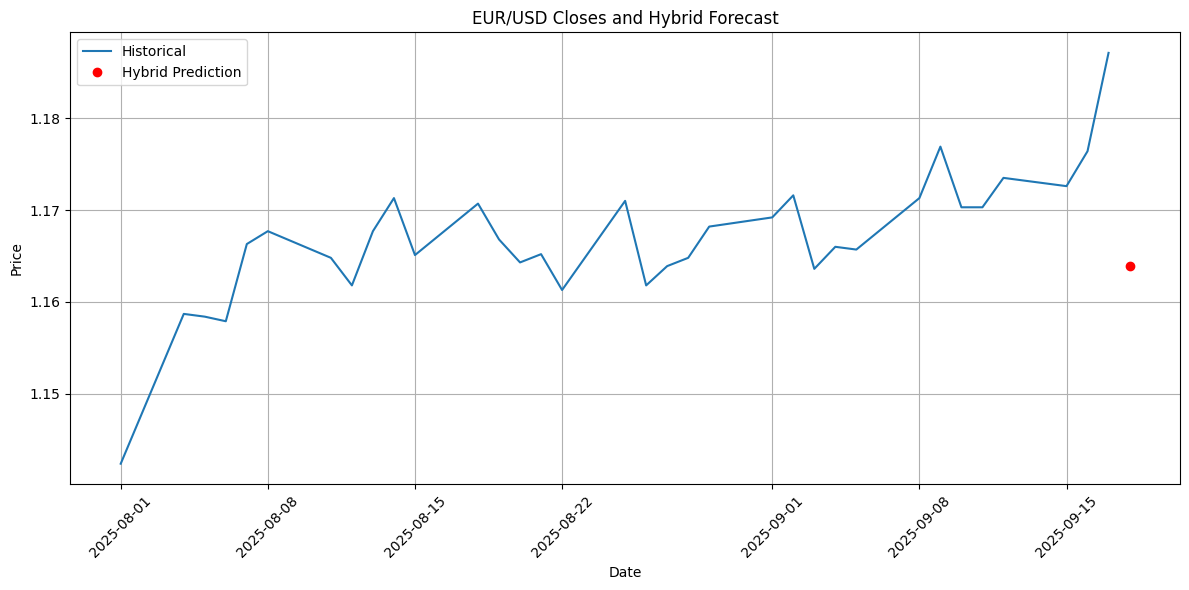

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from collections import deque
import random
import copy

# Historical EUR/USD data (Aug 1 - Sep 17, 2025)
data = {
    'Date': [
        '2025-08-01', '2025-08-04', '2025-08-05', '2025-08-06', '2025-08-07',
        '2025-08-08', '2025-08-11', '2025-08-12', '2025-08-13', '2025-08-14',
        '2025-08-15', '2025-08-18', '2025-08-19', '2025-08-20', '2025-08-21',
        '2025-08-22', '2025-08-25', '2025-08-26', '2025-08-27', '2025-08-28',
        '2025-08-29', '2025-09-01', '2025-09-02', '2025-09-03', '2025-09-04',
        '2025-09-05', '2025-09-08', '2025-09-09', '2025-09-10', '2025-09-11',
        '2025-09-12', '2025-09-15', '2025-09-16', '2025-09-17'
    ],
    'Close': [
        1.1424, 1.1587, 1.1584, 1.1579, 1.1663, 1.1677, 1.1648, 1.1618,
        1.1677, 1.1713, 1.1651, 1.1707, 1.1668, 1.1643, 1.1652, 1.1613,
        1.1710, 1.1618, 1.1639, 1.1648, 1.1682, 1.1692, 1.1716, 1.1636,
        1.1660, 1.1657, 1.1713, 1.1769, 1.1703, 1.1703, 1.1735, 1.1726,
        1.1764, 1.1871
    ]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

seq_length = 14
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_data, seq_length)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Corrected Positional Encoding
def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # Shape: (1, seq_len, d_model) for broadcasting

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256),
            num_layers
        )
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.embedding(x) + get_positional_encoding(seq_len, self.embedding.out_features).to(x.device)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        out = self.transformer(x)
        out = out[-1, :, :]  # Last time step
        out = self.fc(out)
        return out

# Hybrid LSTM-Transformer Model
class HybridModel(nn.Module):
    def __init__(self, input_size=1, lstm_hidden=50, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden, batch_first=True)
        self.embedding = nn.Linear(lstm_hidden, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256),
            num_layers
        )
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        batch_size, seq_len, _ = out.shape
        out = self.embedding(out) + get_positional_encoding(seq_len, self.embedding.out_features).to(out.device)
        out = out.permute(1, 0, 2)
        trans_out = self.transformer(out)
        out = trans_out[-1, :, :]
        out = self.fc(out)
        return out

# Training Function
def train_model(model, loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    return model

# RL Components (DQN for Trading Enhancement)
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_size, action_size=3):  # Actions: 0=buy, 1=sell, 2=hold
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# RL Training
def train_rl(hybrid_model, scaled_data, seq_length, episodes=100, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, batch_size=32, lr=0.001):
    state_size = 2  # Current price + forecast
    action_size = 3
    replay_buffer = ReplayBuffer()
    q_network = DQN(state_size, action_size).to(device)
    target_network = copy.deepcopy(q_network).to(device)
    optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for episode in range(episodes):
        total_reward = 0
        position = 0
        cash = 10000
        for t in range(seq_length, len(scaled_data) - 1):
            seq = torch.tensor(scaled_data[t - seq_length:t].reshape(1, seq_length, 1), dtype=torch.float32).to(device)
            with torch.no_grad():
                forecast = hybrid_model(seq).item()
            state = np.array([scaled_data[t][0], forecast])
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)

            if random.random() < epsilon:
                action = random.randint(0, action_size - 1)
            else:
                with torch.no_grad():
                    action = torch.argmax(q_network(state_tensor.unsqueeze(0))).item()

            current_price = scaler.inverse_transform([[scaled_data[t][0]]])[0][0]
            next_price = scaler.inverse_transform([[scaled_data[t + 1][0]]])[0][0]
            reward = 0
            if action == 0 and position == 0:
                position = 1
                buy_price = current_price
            elif action == 1 and position == 1:
                position = 0
                reward = (next_price - buy_price) * 100
                cash += reward
            elif action == 2:
                if position == 1:
                    reward = (next_price - buy_price) * 0.01

            next_state = np.array([scaled_data[t + 1][0], forecast])
            done = (t == len(scaled_data) - 2)
            replay_buffer.push(state, action, reward, next_state, done)
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
                actions = torch.tensor(actions, dtype=torch.long).to(device).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = q_network(states).gather(1, actions).squeeze()
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if episode % 10 == 0:
            target_network.load_state_dict(q_network.state_dict())
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return q_network

# Main Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Models
lstm_model = LSTMModel().to(device)
lstm_model = train_model(lstm_model, train_loader)

transformer_model = TransformerModel().to(device)
transformer_model = train_model(transformer_model, train_loader)

hybrid_model = HybridModel().to(device)
hybrid_model = train_model(hybrid_model, train_loader)

# Train RL with Hybrid
rl_model = train_rl(hybrid_model, scaled_data, seq_length)

# Forecast September 18, 2025
last_seq = torch.tensor(scaled_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32).to(device)
with torch.no_grad():
    lstm_pred = scaler.inverse_transform(lstm_model(last_seq).cpu().numpy())[0][0]
    trans_pred = scaler.inverse_transform(transformer_model(last_seq).cpu().numpy())[0][0]
    hybrid_pred = scaler.inverse_transform(hybrid_model(last_seq).cpu().numpy())[0][0]

print(f"LSTM Prediction for 2025-09-18: {lstm_pred:.5f}")
print(f"Transformer Prediction for 2025-09-18: {trans_pred:.5f}")
print(f"Hybrid (LSTM+Transformer) Prediction for 2025-09-18: {hybrid_pred:.5f}")

# RL Trading Action
last_price_scaled = scaled_data[-1][0]
with torch.no_grad():
    forecast_scaled = hybrid_model(last_seq).cpu().item()
state = torch.tensor([last_price_scaled, forecast_scaled], dtype=torch.float32).to(device)
action = torch.argmax(rl_model(state.unsqueeze(0))).item()
actions = {0: "Buy", 1: "Sell", 2: "Hold"}
print(f"RL Suggested Action for 2025-09-18: {actions[action]} (based on hybrid forecast)")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical')
pred_date = pd.to_datetime('2025-09-18')
plt.plot(pred_date, hybrid_pred, 'ro', label='Hybrid Prediction')
plt.title('EUR/USD Closes and Hybrid Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eurusd_advanced_forecast.png')
print("Plot saved as 'eurusd_advanced_forecast.png'")
plt.show()